In [54]:
! pip install graphviz

Defaulting to user installation because normal site-packages is not writeable


In [55]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics 
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
import pydotplus
from sklearn.model_selection import KFold
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import LeaveOneOut
from sklearn import svm

In [71]:
training_df = pd.read_csv("./training_preprocessed.csv")
test_df = pd.read_csv("./test_preprocessed.csv")
y = training_df['Target']
training_df = training_df.drop('Target', axis=1)

# Balancing unbalanced data

First of all, we will make sure that the training data is balanced, we will use the ADASYN algorithm for oversampling the minority class and then we will use the Tomek-Link algorithm for undersampling the majority class

In [72]:
oversample = ADASYN(random_state = 42, sampling_strategy='minority')
training_df, y = oversample.fit_resample(training_df, y)
adasyn_data = pd.concat([pd.DataFrame(training_df),pd.DataFrame(y, columns=['Target'])], axis=1)
print(adasyn_data['Target'].value_counts())

TypeError: ADASYN.__init__() got an unexpected keyword argument 'ratio'

In [58]:

# Create an instance of TomekLinks with the defined parameters
tomek_links = TomekLinks(sampling_strategy='majority')

# Apply Tomek Links to the dataset
X_resampled, y_resampled = tomek_links.fit_resample(training_df, y)

# Convert the resampled data back to pandas DataFrame and Series if needed
training_df = pd.DataFrame(X_resampled, columns=training_df.columns)
y = pd.Series(y_resampled)
print(y.value_counts())

1    420
0    364
Name: Target, dtype: int64


# Decision Tree Classifier

Making simple decisionTreeClassifier with cross validation method

In [59]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(training_df, y, test_size=0.25, random_state=42)

# Initialize the decision tree classifier
DTC = DecisionTreeClassifier(random_state=42)

# Fit the classifier on the training data
DTC.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = DTC.predict(X_test)

# Calculate the accuracy score
accuracy = metrics.accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy Score:", accuracy)
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))

Accuracy Score: 0.7193877551020408


0   1
0  69  31
1  24  72

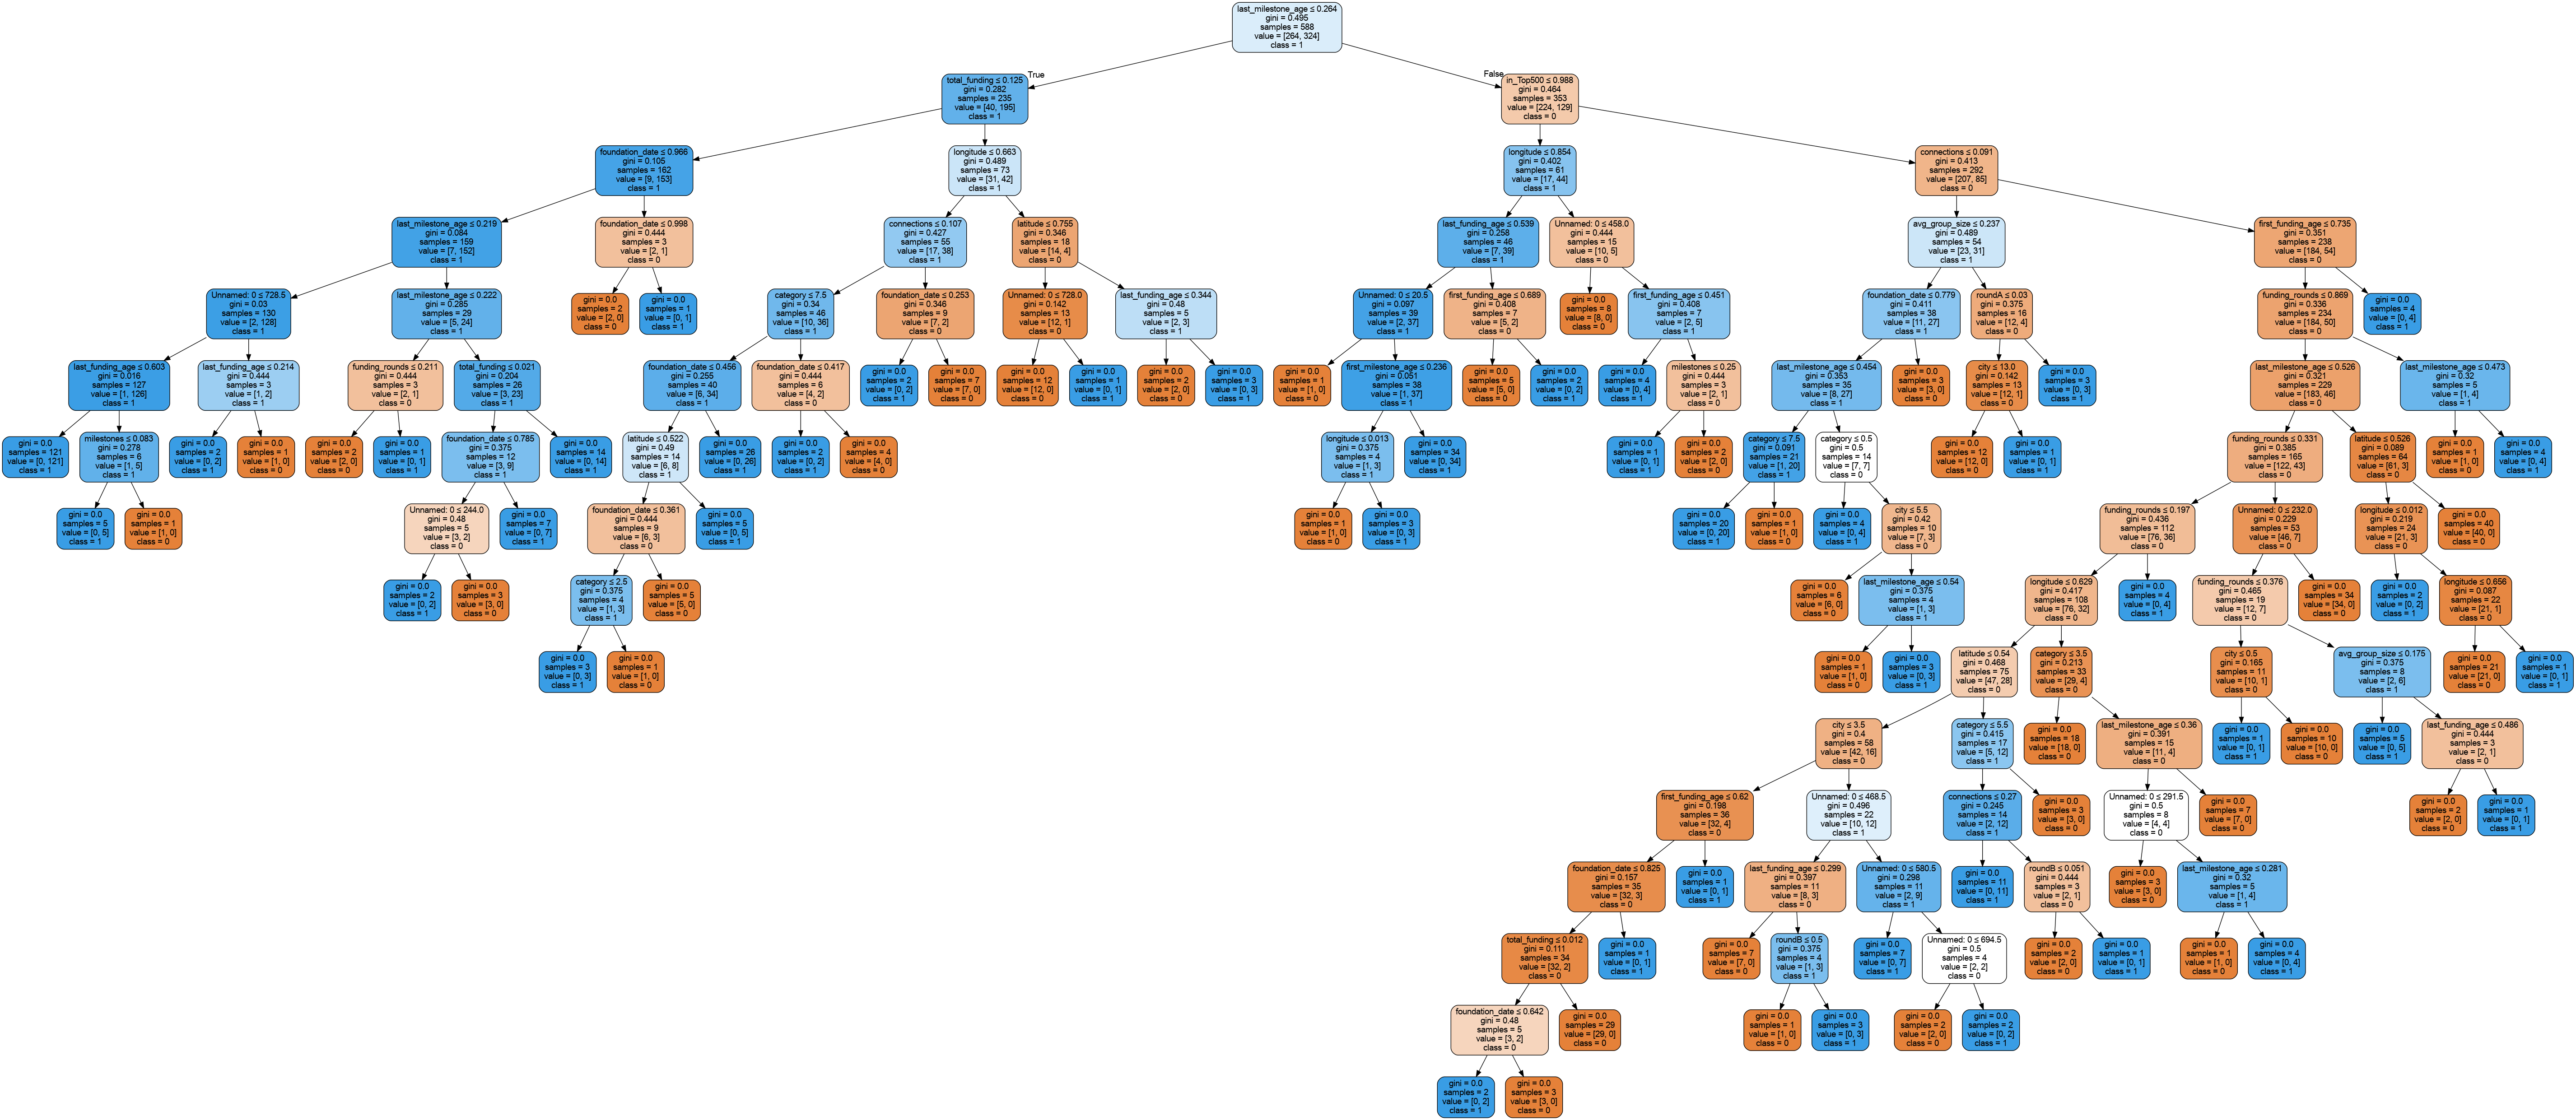

In [60]:
dot = export_graphviz(DTC, filled=True, rounded=True, 
                special_characters=True,feature_names = training_df.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot)  
graph.write_png('tree1.png')
Image(graph.create_png())

We can see in the DTC that it is overfitting, we will prove it with an example

In [61]:
y_train_pred = DTC.predict(X_train)
print(metrics.accuracy_score(y_train, y_train_pred))
pd.DataFrame(metrics.confusion_matrix(y_train, y_train_pred))

1.0


0    1
0  264    0
1    0  324

We will now change the DTC parameters so it wont overfit and we will find the one with maximun accuracy

min_samples_leaf: 12, accuracy: 0.7551020408163265


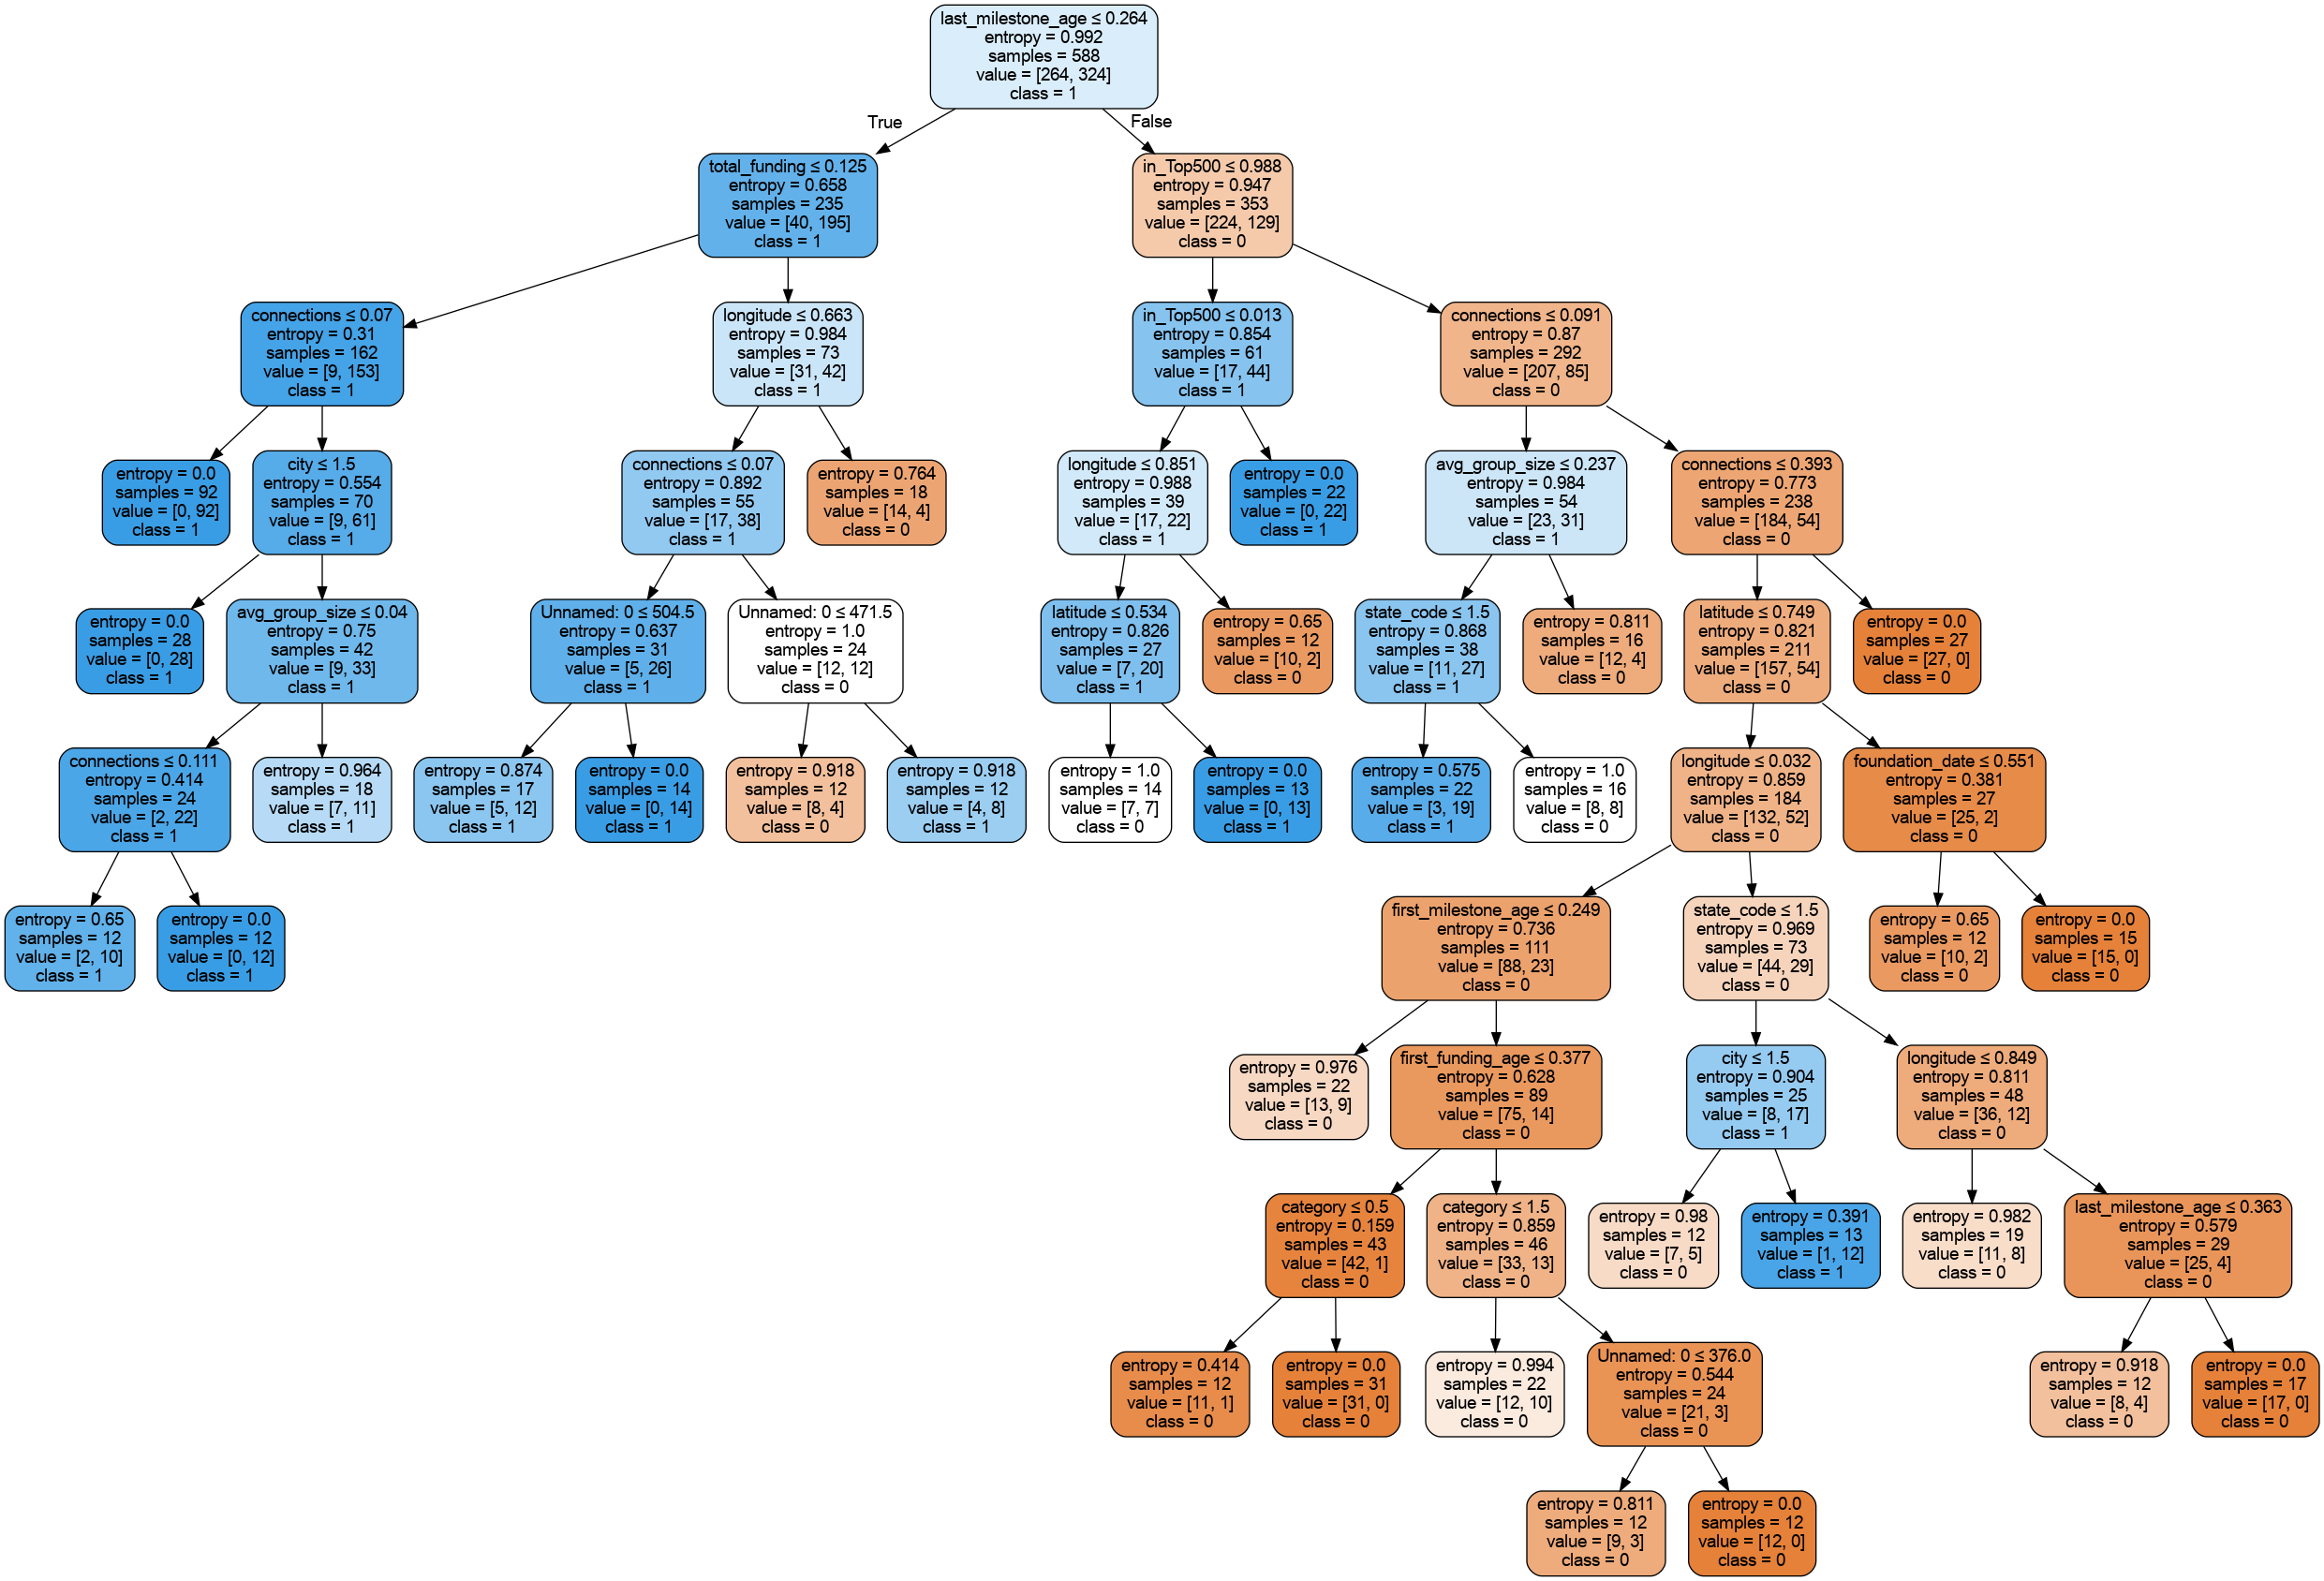

In [62]:
best_min_samples_leaf = 1
best_accuracy = 0
accuracies = []
best_DTC = None
for min_samples_leaf in range(1,50):
    DTC2 = DecisionTreeClassifier(criterion='entropy', splitter='best', min_samples_leaf = min_samples_leaf, random_state=42) 
    DTC2 = DTC2.fit(X_train,y_train)
    y_pred = DTC2.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_min_samples_leaf = min_samples_leaf
            best_DTC = DTC2
            
print(f'min_samples_leaf: {best_min_samples_leaf}, accuracy: {best_accuracy}')

dot = export_graphviz(best_DTC, filled=True, rounded=True, 
                special_characters=True,feature_names = training_df.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot)
graph.write_png('./Pics/tree2.png')
Image(graph.create_png())

We saw that min_samples_leaf 32 is the best in accuracy and preventing overfitting, but now we want to test if its true for kFolds splitting and not only one validation split of the data

In [63]:
best_min_samples_leaf = 1
best_precision = 0
best_accuracy = 0
accuracies = []
precisions = []
best_DTC = None
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train = training_df.to_numpy()
for min_samples_leaf in range(1,50):
    cm = []
    precision = []
    for train_index, test_index in kf.split(train):
        X_train, X_test = train[train_index], train[test_index]
        y_train, y_test = y[train_index], y[test_index]

        DTC2 = DecisionTreeClassifier(criterion='entropy', splitter='best', min_samples_leaf = min_samples_leaf, random_state=42) 

        DTC2.fit(X_train, y_train)
        y_pred = DTC2.predict(X_test)
        cm.append(metrics.confusion_matrix(y_test, y_pred))
        precision.append(metrics.precision_score(y_test, y_pred, average='weighted'))

    result_cm = np.zeros((2,2))
    for matrix in cm:
        result_cm += matrix
    result_cm = result_cm/len(cm)
    acc = (result_cm[0][0]+result_cm[1][1])/(result_cm[0][0]+result_cm[0][1]+result_cm[1][0]+result_cm[1][1])
    prs = np.average(precision)

    accuracies.append(acc)
    precisions.append(prs)
    if acc > best_accuracy:
            best_accuracy = acc
            best_precision = prs
            best_min_samples_leaf = min_samples_leaf
            best_DTC = DTC2
print(f'min_samples_leaf: {best_min_samples_leaf}, precision: {best_precision}, acuurecy: {best_accuracy}')



min_samples_leaf: 3, precision: 0.747815187942865, acuurecy: 0.7474489795918366


we want to see the graphs of the accurecy and presicion as a function of the min_samples_tree to choose the best parameter

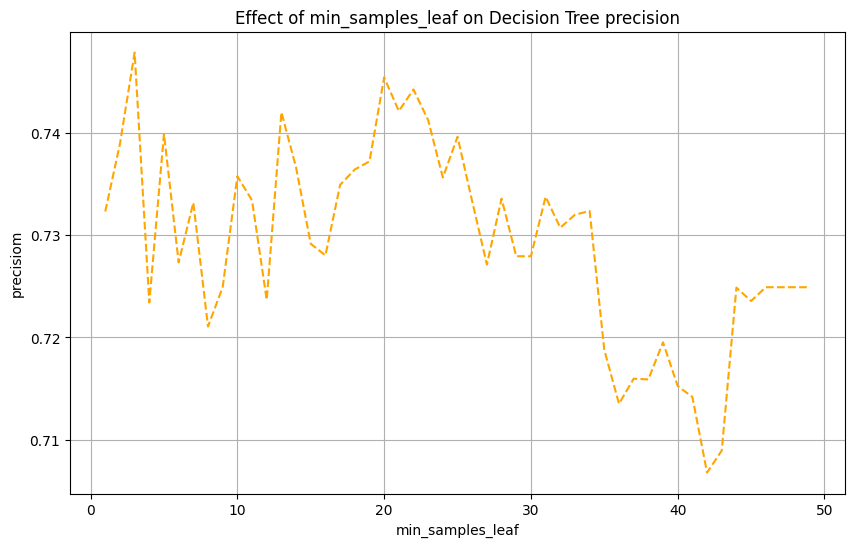

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(1, 50), precisions, linestyle='--', color='orange')

ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('precisiom')
ax.set_title('Effect of min_samples_leaf on Decision Tree precision')
ax.grid()
plt.show()

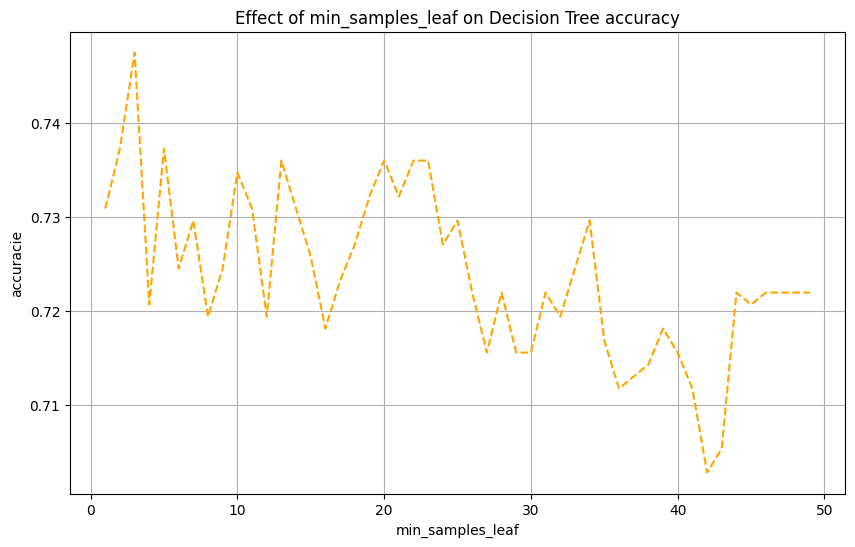

In [65]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(1, 50), accuracies, linestyle='--', color='orange')

ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('accuracie')
ax.set_title('Effect of min_samples_leaf on Decision Tree accuracy')
ax.grid()
plt.show()

We noticed that the graphes looks very similar but they are not the same around 28 so its fine, also min_samples_leaf = 46 is the best parameter as its not overfittinh and as the highest accurecy and very close to the highest precision, we will show the DTC

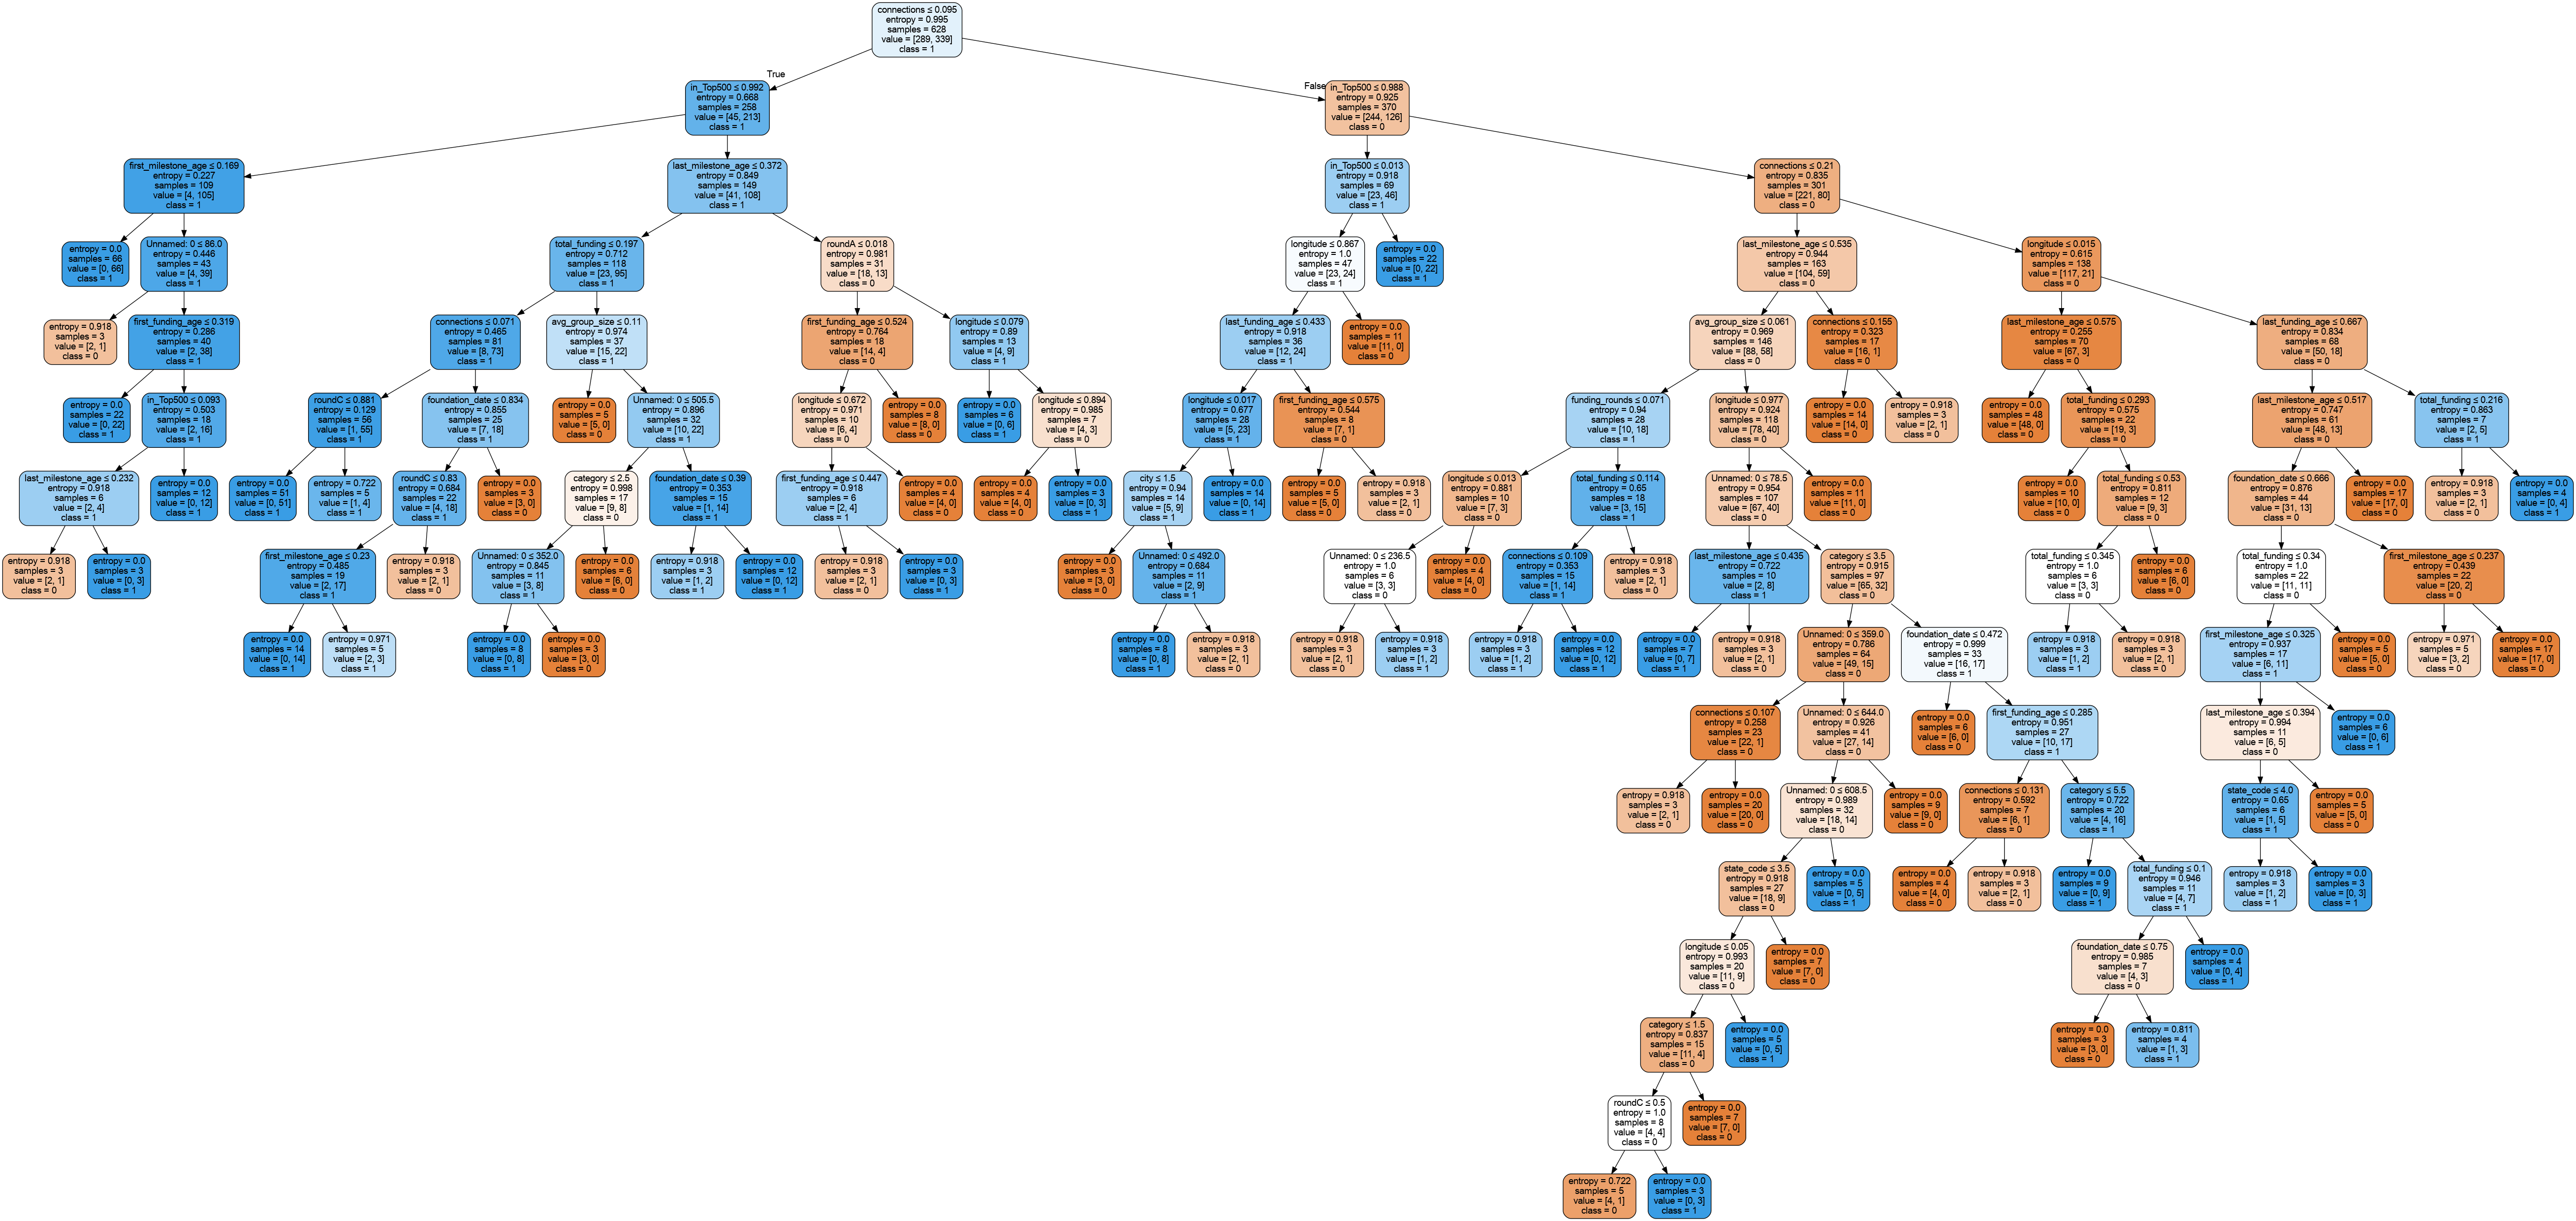

In [66]:
dot = export_graphviz(best_DTC, filled=True, rounded=True, 
                special_characters=True,feature_names = training_df.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot)
graph.write_png('./Pics/tree2.png')
Image(graph.create_png())

Pruning - didnt work out

In [67]:
# path = DTC2.cost_complexity_pruning_path(X_train, y_train)
# ccp_alphas = path.ccp_alphas
# accuracies = []
# for i in ccp_alphas:
#     pruned_classifier = DecisionTreeClassifier(random_state=42, ccp_alpha=i, min_samples_leaf = 32)
#     pruned_classifier.fit(X_train, y_train)
#     y_pred = pruned_classifier.predict(X_test)
#     accuracy = metrics.accuracy_score(y_test, y_pred)
#     accuracies.append(accuracy)
#     print("Best alpha for pruning:", i)
#     print("Accuracy after pruning:", accuracy)
    
# # Choose the best ccp_alpha that maximizes the accuracy
# best_alpha = ccp_alphas[np.argmax(accuracies)]
# pruned_classifier = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha, min_samples_leaf = 32)
# pruned_classifier.fit(X_train, y_train)
# y_pred = pruned_classifier.predict(X_test)
# accuracy_after_pruning = metrics.accuracy_score(y_test, y_pred)
# print("Best alpha for pruning:", best_alpha)
# print("Accuracy after pruning:", accuracy_after_pruning)

# dot = export_graphviz(pruned_classifier, filled=True, rounded=True, 
#                 special_characters=True,feature_names = training_df.columns,class_names=['0','1'])
# graph = pydotplus.graph_from_dot_data(dot)
# graph.write_png('./Pics/tree2.png')
# Image(graph.create_png())

# Random Forest

Instead of a spacific decision tree we will try to average several decision trees.
We will try first to find the best parameters to the trees

In [68]:
random_parameters = {'criterion' : ['gini', 'entropy'],
                     'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90 ,100],
                     'max_depth' : [4 ,5, 6, 7, 8, None],
                     'min_samples_leaf': [5, 10, 15, 20, 25, 30],
                     'min_samples_split' : [10, 15, 20, 25, 30, 35],
                     'max_features' : ['auto', 'log2']}
RFC = RandomizedSearchCV(estimator = RandomForestClassifier(random_state = 42), param_distributions = random_parameters
                         , n_iter = 100, cv = 5, verbose=2, random_state = 42, n_jobs = -1)
RFC.fit(X_train, y_train)
best_RFC = RFC.best_estimator_
random_y_pred = best_RFC.predict(X_test)
random_accuracy = metrics.accuracy_score(y_test, random_y_pred)
print('random model accuracy = {:0.2f}%'.format(random_accuracy*100))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=25, min_samples_split=15, n_estimators=10; total time=   0.1s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=25, min_samples_split=15, n_estimators=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=30, min_samples_split=20, n_estimators=60; total time=   0.2s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=25, min_samples_split=15, n_estimators=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=25, min_samples_split=15, n_estimators=10; total time=   0.1s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=25, min_samples_split=15, n_estimators=10; total time=   0.1s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=30, min_samples_split=20, n_estimators=60; total time=   0.2s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=30, min_samples_split=20, n_estimators=60; total time=   0.2s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=30, min_samples_split=20, n_estimators=60; total time=   0.3s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=30, min_samples_split=20, n_estimators=60; total time=   0.2s
[CV] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=30, n_estimators=30; total time=   0.1s
[CV] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=30, n_estimators=30; total time=   0.1s
[CV] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=30, n_estimators=30; total time=   0.1s
[CV] END criterion=gini, max_depth=4

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=20, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=20, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=20, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=20, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=20, n_estimators=50; total time=   0.2s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=30; total time=   0.1s
[CV] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=30, min_samples_split=15, n_estimators=90; total time=   0.3s
[CV] END criterion=entropy, max_dep

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=30; total time=   0.2s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=30; total time=   0.1s
[CV] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=30, min_samples_split=15, n_estimators=90; total time=   0.3s
[CV] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=30, min_samples_split=15, n_estimators=90; total time=   0.3s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=30; total time=   0.2s
[CV] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=30, min_samples_split=15, n_estimators=90; total time=   0.3s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=70; total time=   0.3s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=70; total time=   0.3s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=70; total time=   0.3s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=70; total time=   0.4s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=25, n_estimators=80; total time=   0.4s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=30; total time=   0.2s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=25, n_estimators=80; total time=   0.4s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=25, n_estimators=80; total time=   0.4s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=25, n_estimators=80; total time=   0.5s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=30; total time=   0.2s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=70; total time=   0.6s
[CV] END criterio

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=20, min_samples_split=30, n_estimators=100; total time=   0.7s
[CV] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=20, min_samples_split=30, n_estimators=100; total time=   0.8s
[CV] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=20, min_samples_split=30, n_estimators=100; total time=   0.8s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=20, n_estimators=80; total time=   0.4s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=20, n_estimators=80; total time=   0.4s
[CV] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=10, n_estimators=40; total time=   0.2s
[CV] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=10, n_estimators=40; total time=   0.3s
[CV] END criterion=gini, max_dept

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=10, n_estimators=30; total time=   0.4s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=20, n_estimators=90; total time=   0.5s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=15, n_estimators=50; total time=   0.4s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=20, n_estimators=90; total time=   0.5s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=20, n_estimators=90; total time=   0.7s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=15, n_estimators=50; total time=   0.3s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=20, n_estimators=90; total time=   0.7s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=15, n_estimators=50; total time=   0.6s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=15, n_estimators=50; total time=   0.6s[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=20, n_estimators=90; total time=   0.8s



/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=15, n_estimators=50; total time=   0.5s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=70; total time=   0.5s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=70; total time=   0.4s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=35, n_estimators=60; total time=   0.3s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=35, n_estimators=60; total time=   0.3s
[CV] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=30, n_estimators=30; total time=   0.2s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=70; total time=   0.8s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=70; total time=   1.0s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=35, n_estimators=60; total time=   0.9s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=35, n_estimators=60; total time=   0.7s
[CV] END criterion=entropy, max_depth=7, 

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=25, min_samples_split=15, n_estimators=80; total time=   0.4s
[CV] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=25, min_samples_split=15, n_estimators=80; total time=   0.5s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=25, min_samples_split=15, n_estimators=80; total time=   0.7s
[CV] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=25, min_samples_split=15, n_estimators=80; total time=   0.8s
[CV] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=25, min_samples_split=15, n_estimators=80; total time=   0.9s
[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=30, n_estimators=100; total time=   0.7s
[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=30, n_estimators=100; total time=   0.5s
[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=30, n_estimators=100; total time=   0.7s
[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=30, n_estimators=100; total time=   0.8s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=30, min_samples_split=30, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=15, n_estimators=90; total time=   0.7s
[CV] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=15, n_estimators=90; total time=   0.7s
[CV] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=15, n_estimators=90; total time=   0.5s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=30, min_samples_split=35, n_estimators=70; total time=   0.5s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=30, min_samples_split=35, n_estimators=70; total time=   0.5s
[CV] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=15, n_estimators=90; total time=   0.7s
[CV] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=15, n_estimators=90; total time=   0.9s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=40; total time=   0.2s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=30, min_samples_split=35, n_estimators=70; total time=   0.7s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=30, min_samples_split=35, n_estimators=70; total time=   0.4s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=30, min_samples_split=35, n_estimators=70; total time=   0.5s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=40; total time=   0.2s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=40; total time=   0.3s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=40; total time=   0.5s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=40; total time=   0.5s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=90; total time=   0.5s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=90; total time=   0.6s[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=90; total time=   0.7s

[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=25, n_estimators=20; total time=   0.1s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=90; total time=   0.7s
[CV] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=80; total time=   0.6s
[CV] END criterion=entropy, max_depth=5, max_feat

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=20, n_estimators=60; total time=   0.3s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=20, n_estimators=60; total time=   0.3s
[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=100; total time=   0.5s
[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=100; total time=   0.6s
[CV] END crit

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=100; total time=   0.8s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=100; total time=   0.7s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=70; total time=   0.5s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=70; total time=   0.5s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=70; total time=   0.4s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=70; total time=   0.6s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=60; total time=   0.4s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=70; total time=   0.6s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=60; total time=   0.4s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=60; total time=   0.3s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=25, min_samples_split=20, n_estimators=60; total time=   0.4s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=60; total time=   0.5s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=60; total time=   0.5s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=25, min_samples_split=20, n_estimators=60; total time=   0.4s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=40; total time=   0.2s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=40; total time=   0.2s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=25, min_samples_split=20, n_estimators=60; total time=   0.4s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=25, min_samples_split=20, n_estimators=60; total time=   0.3s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=25, min_samples_split=20, n_estimators=60; total time=   0.4s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=40; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=40; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=40; total time=   0.2s
[CV] END criterion=gini, max_depth=8

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=35, n_estimators=80; total time=   0.4s
[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=35, n_estimators=80; total time=   0.4s
[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=35, n_estimators=80; total time=   0.6s
[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=35, n_estimators=80; total time=   0.7s
[CV] END criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=25, n_estimators=100; total time=   0.7s
[CV] END criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=25, n_estimators=100; total time=   0.7s
[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=35, n_estimators=80; total time=   0.8s
[CV] END criterion=gini, max_dept

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=25, min_samples_split=10, n_estimators=80; total time=   0.6s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=25, min_samples_split=10, n_estimators=80; total time=   0.5s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=25, min_samples_split=10, n_estimators=80; total time=   0.5s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=25, min_samples_split=10, n_estimators=80; total time=   0.5s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30; total time=   0.2s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=25, min_samples_split=10, n_estimators=80; total time=   0.5s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30; total time=   0.2s
[CV] END criterion=entr

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30; total time=   0.2s
[CV] END criterion=gini, max_depth=7, max_features=log2, min_samples_leaf=30, min_samples_split=25, n_estimators=60; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=90; total time=   0.4s
[CV] END criterion=gini, max_depth=7, max_features=log2, min_samples_leaf=30, min_samples_split=25, n_estimators=60; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=90; total time=   0.4s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=90; total time=   0.4s
[CV] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=10; total time=   0.1s
[CV] END criterion=entropy, max_

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=7, max_features=log2, min_samples_leaf=30, min_samples_split=25, n_estimators=60; total time=   0.3s
[CV] END criterion=gini, max_depth=7, max_features=log2, min_samples_leaf=30, min_samples_split=25, n_estimators=60; total time=   0.3s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=20, min_samples_split=20, n_estimators=40; total time=   0.2s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END criterion=gini, max_depth=7, max_fea

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=20, min_samples_split=20, n_estimators=40; total time=   0.2s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=20, min_samples_split=20, n_estimators=40; total time=   0.3s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=20, min_samples_split=20, n_estimators=40; total time=   0.2s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=20, min_samples_split=20, n_estimators=40; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=25, min_samples_split=25, n_estimators=80; total time=   0.4s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=25, min_samples_split=25, n_estimators=80; total time=   0.4s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=25, min_samples_split=25, n_estimators=80; total time=   0.5s
[CV] END criterion=gini, ma

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=15, min_samples_split=20, n_estimators=50; total time=   0.3s
[CV] END criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=15, min_samples_split=20, n_estimators=50; total time=   0.3s
[CV] END criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=15, min_samples_split=20, n_estimators=50; total time=   0.3s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=30, min_samples_split=20, n_estimators=100; total time=   0.5s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=30, min_samples_split=20, n_estimators=100; total time=   0.5s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=30, min_samples_split=20, n_estimators=100; total time=   0.5s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=30, min_samples_split=20, n_estimators=100; total time=   0.5s
[CV] END criterion=entr

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=20, min_samples_split=15, n_estimators=30; total time=   0.2s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=30, n_estimators=90; total time=   0.5s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=30, n_estimators=90; total time=   0.5s
[CV] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=40; total time=   0.2s
[CV] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=40; total time=   0.2s
[CV] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=40; total time=   0.2s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=25, n_estimators=90; total time=   0.5s
[CV] END criterion=entro

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=25, n_estimators=90; total time=   0.5s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=25, n_estimators=90; total time=   0.5s
[CV] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=40; total time=   0.2s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=25, n_estimators=90; total time=   0.6s
[CV] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=30, min_samples_split=10, n_estimators=40; total time=   0.3s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END criterion=gini,

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=20, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=20, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=15, min_samples_split=20, n_estimators=30; total time=   0.2s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=20, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=20, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END criterion=entro

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=15, min_samples_split=10, n_estimators=60; total time=   0.3s
[CV] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=15, min_samples_split=10, n_estimators=60; total time=   0.3s
[CV] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=15, min_samples_split=10, n_estimators=60; total time=   0.3s
[CV] END criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=15, min_samples_split=10, n_estimators=60; total time=   0.3s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=35, n_estimators=20; total time=   0.1s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=35, n_estimators=20; total time=   0.1s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=35, n_estimators=20; total time=   0.1s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=35, n_estimators=20; total time=   0.1s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=30, min_samples_split=35, n_estimators=20; total time=   0.1s
[CV] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=100; total time=   0.6s
[CV] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=100; total time=   0.5s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=10; total time=   0.1s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=10; total time=   0.1s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=10; total time=   0.1s
[CV] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=100; total time=   0.6s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=10; total time=   0.1s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=10; total time=   0.1s
[CV] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=25, min_samples_split=30, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=5, max_feat

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.8s
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.9s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=15, min_samples_split=10, n_estimators=80; total time=   0.4s
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.8s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.9s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=15, min_samples_split=10, n_estimators=80; total time=   0.6s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=15, min_samples_split=10, n_estimators=80; total time=   0.6s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=15, min_samples_split=10, n_estimators=80; total time=   0.8s
[CV] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=15, min_samples_split=15, n_estimators=80; total time=   0.5s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=15, min_samples_split=10, n_estimators=80; total time=   0.6s
[CV] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=15, min_samples_split=15, n_estimators=80; total time=   0.5s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=15, min_samples_split=15, n_estimators=80; total time=   0.4s
[CV] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=15, min_samples_split=15, n_estimators=80; total time=   0.6s
[CV] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=15, min_samples_split=15, n_estimators=80; total time=   0.7s
[CV] END criterion=gini, max_depth=7, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.2s
[CV] END criterion=gini, max_depth=7, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.2s
[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=25, min_samples_split=20, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=25, min_samples_split=20, n_estimators=100; total time=   0.6s
[CV] END criterion=gini, max_de

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=25, min_samples_split=20, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=7, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.2s
[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=25, min_samples_split=20, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=25, min_samples_split=20, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=15, min_samples_split=10, n_estimators=30; total time=   0.2s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=15, min_samples_split=10, n_estimators=30; total time=   0.2s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=35, n_estimators=70; total time=   0.4s
[CV] END criterion=entropy, 

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=35, n_estimators=70; total time=   0.5s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=35, n_estimators=70; total time=   0.6s
[CV] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=20, min_samples_split=20, n_estimators=20; total time=   0.1s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=15, min_samples_split=10, n_estimators=30; total time=   0.2s
[CV] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=20, min_samples_split=20, n_estimators=20; total time=   0.1s
[CV] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=20, min_samples_split=20, n_estimators=20; total time=   0.1s
[CV] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=20, min_samples_split=20, n_estimators=20; total time=   0.2s
[CV] END criterion=entropy, m

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=20, n_estimators=20; total time=   0.2s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=20, n_estimators=20; total time=   0.2s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=20, n_estimators=20; total time=   0.2s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=20, n_estimators=20; total time=   0.1s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=30, min_samples_split=20, n_estimators=20; total time=   0.1s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=25, min_samples_split=30, n_estimators=90; total time=   0.5s
[CV] END criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=25, min_samples_split=30, n_estimators=90; total time=   0.6s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.2s
[CV] END criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=25, min_samples_split=30, n_estimators=90; total time=   0.6s
[CV] END criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=25, min_samples_split=30, n_estimators=90; total time=   0.7s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.3s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=25, min_samples_split=30, n_estimators=90; total time=   0.7s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.3s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.4s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.3s
[CV] END criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=25, min_samples_split=20, n_estimators=60; total time=   0.3s
[CV] END criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=25, min_samples_split=20, n_estimators=60; total time=   0.4s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=25, min_samples_split=35, n_estimators=40; total time=   0.3s
[CV] END criterion=entropy,

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=25, min_samples_split=35, n_estimators=40; total time=   0.3s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=30; total time=   0.3s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=30; total time=   0.3s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=30; total time=   0.2s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=70; total time=   0.4s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=70; total time=   0.5s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=30; total time=   0.2s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=70; total time=   0.6s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=70; total time=   0.6s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=30; total time=   0.3s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=70; total time=   0.7s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=60; total time=   0.3s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=60; total time=   0.4s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=60; total time=   0.4s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=60; total time=   0.3s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=35, n_estimators=60; total time=   0.3s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=25, min_samples_split=10, n_estimators=60; total time=   0.4s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=35, n_estimators=60; total time=   0.4s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=35, n_estimators=60; total time=   0.4s

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul


[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=35, n_estimators=60; total time=   0.3s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=20, n_estimators=70; total time=   0.4s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=20, n_estimators=70; total time=   0.4s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=20, n_estimators=70; total time=   0.4s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=35, n_estimators=60; total time=   0.6s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=20, n_estimators=10; total time=   0.1s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=20, n_estimators=70; total time=   0.5s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=20, n_estimators=10; total time=   0.1s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=30, n_estimators=70; total time=   0.6s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=20, n_estimators=10; total time=   0.1s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=30, n_estimators=70; total time=   0.3s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=30, n_estimators=70; total time=   0.5s
[CV] END criterion=gini, max_d

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=30, n_estimators=70; total time=   0.4s
[CV] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=25, min_samples_split=15, n_estimators=30; total time=   0.1s
[CV] END criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=25, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=30, n_estimators=70; total time=   0.4s
[CV] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=25, min_samples_split=15, n_estimators=30; total time=   0.2s
[CV] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=25, min_samples_split=15, n_estimators=30; total time=   0.2s[CV] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=25, min_samples_split=15, n_estimators=30; total time=   0.2s

[CV] END criterion=entropy,

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=5, min_samples_split=35, n_estimators=90; total time=   0.5s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=25, n_estimators=100; total time=   0.5s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=25, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=25, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=5, min_samples_split=35, n_estimators=90; total time=   0.5s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=5, min_samples_split=35, n_estimators=90; total time=   0.5s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=25, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, ma

/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=20, min_samples_split=30, n_estimators=10; total time=   0.1s
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=20, min_samples_split=30, n_estimators=10; total time=   0.2s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=5, min_samples_split=35, n_estimators=90; total time=   0.5s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=5, min_samples_split=35, n_estimators=90; total time=   0.7s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=100; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=80; total time=   0.5s
[CV] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=100; total time=   0.7s
[CV] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=35, n_estimators=100; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=80; total time=   0.4s


/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/boaz/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=10, n_estimators=80; total time=   0.3s
random model accuracy = 78.21%


# KMeans

First of all, we have to normalize the data to the same scale, OW the categorial dataset which we didnt normalized will create muck bigger diffrence in the metric equation.

In [69]:
scaler = MinMaxScaler() 
normalized_training_df = scaler.fit_transform(training_df)

We will try to find the best kmeans models, by init Kmeans++, checking for both silhouette score and SSE score, and runnnig on the number of clustering

Traceback (most recent call last):
  File "/home/boaz/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/boaz/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/boaz/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/home/boaz/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1030, in structured_traceback
    formatted_exception = self.format_exception_as_a_whole(etype, evalue, etb, number_of_lines_of_context,
  File "/home/boaz/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 935, in format_exception_as_a_whole
    self.get_records(etb, number_of_lines_of_context, tb_offset) if etb else []
  File "/home/boaz/.local/lib/python3.10/site-packa

Unexpected exception formatting exception. Falling back to standard exception


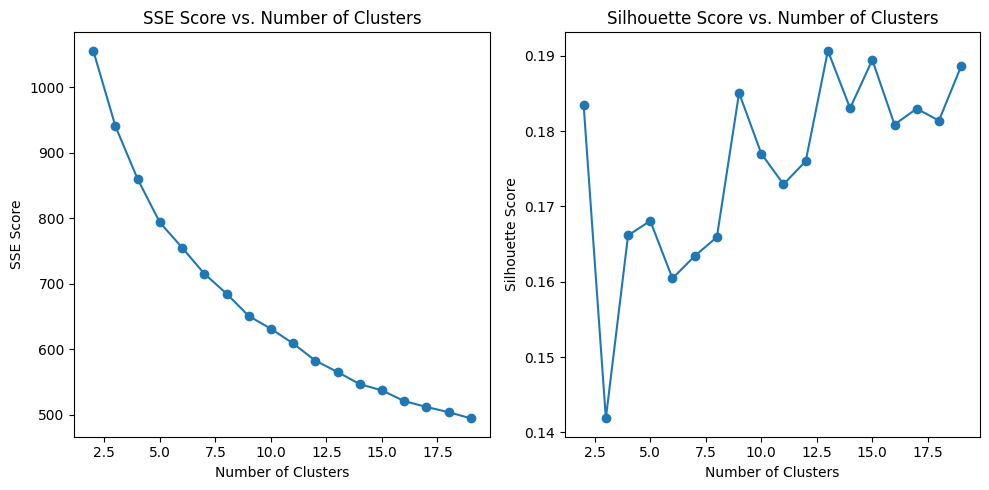

In [70]:
sse_scores = []
silhouette_scores = []
num_clusters = range(2,20)
for n_clusters in num_clusters:
    # Create KMeans object with K-means++ initialization
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init = 20, max_iter = 100, random_state = 42)
    kmeans.fit(normalized_training_df)

    sse = kmeans.inertia_
    sse_scores.append(sse)

    labels = kmeans.labels_
    silhouette = silhouette_score(normalized_training_df, labels)
    silhouette_scores.append(silhouette)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(num_clusters, sse_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE Score')
plt.title('SSE Score vs. Number of Clusters')

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(num_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')

# Display the plot
plt.tight_layout()
plt.show()


Num of clusters = 16, we will check the accurecy of the algorithem

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(normalized_training_df, y, test_size=0.25, random_state=42)
kmeans = KMeans(n_clusters=16, init='k-means++', n_init = 20, max_iter = 100, random_state = 42)
kmeans.fit(X_test)
labels = kmeans.predict(X_test)
class_mapping = {}

for cluster in range(16):
    cluster_indices = np.where(labels == cluster)[0]
    class_labels = y[cluster_indices]  # Assuming you have the original class labels stored in y

    majority_class = np.argmax(np.bincount(class_labels))
    class_mapping[cluster] = majority_class

# Map the cluster labels to the original classes
predicted_classes = [class_mapping[cluster] for cluster in labels]
cm = pd.DataFrame(metrics.confusion_matrix(y_test, predicted_classes))
print(cm)
acc = (cm[0][0] + cm[1][1])/(cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
print(acc)

    0   1
0  82  18
1  87   9
0.4642857142857143


In [ ]:
# loo = LeaveOneOut()
# cm_list = []
# for train_index, test_index in loo.split(normalized_training_df):
#     X_train, X_test = normalized_training_df[train_index], normalized_training_df[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     kmeans = KMeans(n_clusters=16, init='k-means++', n_init = 20, max_iter = 100, random_state = 42)
#     kmeans.fit(X_train)
#     labels = kmeans.predict(X_test)
#     class_mapping = {}

#     for cluster in range(16):
#         cluster_indices = np.where(labels == cluster)[0]
#         class_labels = y[cluster_indices]  # Assuming you have the original class labels stored in y

#         if len(class_labels) > 0:
#             majority_class = np.argmax(np.bincount(class_labels))
#             class_mapping[cluster] = majority_class

#     # Map the cluster labels to the original classes
#     predicted_classes = [class_mapping[cluster] for cluster in labels]
#     cm = pd.DataFrame(metrics.confusion_matrix(y_test, predicted_classes))
#     cm_list.append(cm)
# cm = sum(cm_list)/len(cm_list)
# print(cm)


# SVM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(normalized_training_df, y, test_size=0.25, random_state=42) 
clf_a = svm.SVC(kernel='poly', C=0.9, probability=True)
clf_a.fit(X_train, y_train)
y_pred = clf_a.predict(X_test)
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)))
print(metrics.classification_report(y_test,y_pred))

    0   1
0  70  30
1  17  79
              precision    recall  f1-score   support

           0       0.80      0.70      0.75       100
           1       0.72      0.82      0.77        96

    accuracy                           0.76       196
   macro avg       0.76      0.76      0.76       196
weighted avg       0.77      0.76      0.76       196

